In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import holidays
from scipy import stats
from sklearn.metrics import matthews_corrcoef, r2_score, mean_squared_error
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
import scipy.cluster.hierarchy as sch
from scipy.stats import pointbiserialr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pmdarima.arima import auto_arima

In [2]:
generation_df = pd.read_csv('generation.csv', sep=';',parse_dates=['DateTime'], decimal= ',')
temperature_df = pd.read_csv('temperature.csv', sep=';',parse_dates=['DateTime'], decimal= ',')
print("Generation Data")
display(generation_df.head())
print("Temperature Data")
display(temperature_df.head())

Generation Data


,DateTime,Generation
0,2019-01-01 00:00:00,0.000000
1,2019-01-01 01:00:00,0.000000
2,2019-01-01 02:00:00,0.000008
3,2019-01-01 03:00:00,0.000000
4,2019-01-01 04:00:00,0.000008


Temperature Data


,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
0,2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3
1,2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5
2,2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5
3,2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6
4,2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5


In [3]:
generation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DateTime    25560 non-null  datetime64[ns]
 1   Generation  25560 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 411.1 KB


In [4]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26399 entries, 0 to 26398
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DateTime             26304 non-null  datetime64[ns]
 1   AirTemperature       26304 non-null  float64       
 2   ComfortTemperature   26304 non-null  float64       
 3   RelativeHumidity     26304 non-null  float64       
 4   WindSpeed            26304 non-null  float64       
 5   WindDirection        26304 non-null  float64       
 6   WWCode               20050 non-null  float64       
 7   EffectiveCloudCover  26304 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.6 MB


In [5]:
#Drop the empty rows
generation_df.dropna(axis=0, inplace=True)
temperature_df.dropna(how='all', axis=0, inplace=True)

#Adjust the datetime columns to the index
generation_df.set_index('DateTime', inplace=True)
temperature_df.set_index('DateTime', inplace=True)
print("Generation")
display(generation_df.head())
print("Temperature")
display(temperature_df.head())

Generation


,Generation
DateTime,
2019-01-01 00:00:00,0.000000
2019-01-01 01:00:00,0.000000
2019-01-01 02:00:00,0.000008
2019-01-01 03:00:00,0.000000
2019-01-01 04:00:00,0.000008


Temperature


,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
DateTime,,,,,,,
2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3
2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5
2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5
2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6
2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5


In [6]:
print("Generation")
display(generation_df.describe())
print("Temperature")
display(temperature_df.describe().T)

Generation


,Generation
count,25560.000000
mean,89.724239
std,126.180117
min,0.000000
25%,0.000000
50%,4.317082
75%,168.498464
max,456.319322


Temperature


,count,mean,std,min,25%,50%,75%,max
AirTemperature,26304.0,13.741522,9.379876,-13.1,6.0,13.4,21.0,39.0
ComfortTemperature,26304.0,13.239397,9.767058,-19.3,5.1,13.0,21.2,37.2
RelativeHumidity,26304.0,54.352832,22.566688,1.6,36.6,55.1,72.5,100.0
WindSpeed,26304.0,1.655931,1.353196,0.0,0.5,1.5,2.6,13.4
WindDirection,26304.0,87.463960,100.762932,0.0,20.0,30.0,170.0,360.0
WWCode,20050.0,13.095711,24.471306,0.0,0.0,3.0,10.0,99.0
EffectiveCloudCover,26304.0,2.614051,2.497609,0.0,0.0,2.1,5.0,8.0


**Missing Control**

In [7]:
temperature_df.columns[temperature_df.isna().any()].tolist()

['WWCode']

In [8]:
temperature_df[temperature_df["WWCode"].isna()]

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
DateTime,,,,,,,
2019-01-01 10:00:00,-1.7,-6.5,75.3,4.1,60.0,NaN,2.5
2019-01-01 11:00:00,-1.0,-6.8,72.6,6.2,50.0,NaN,2.5
2019-01-01 12:00:00,-0.7,-5.2,72.7,4.1,50.0,NaN,1.2
2019-01-01 13:00:00,0.5,-4.0,68.7,4.6,40.0,NaN,2.5
2019-01-01 14:00:00,0.5,-3.7,68.7,4.1,50.0,NaN,2.5
...,...,...,...,...,...,...,...
2019-11-22 23:00:00,4.5,4.0,51.3,1.0,20.0,NaN,0.0
2019-11-23 01:00:00,3.9,3.5,54.3,1.0,10.0,NaN,0.0
2019-11-23 02:00:00,3.1,2.8,55.3,1.0,30.0,NaN,0.0


In [25]:
temperature_df["WWCode"].nunique()

54

In [9]:
temperature_df["WWCode"].value_counts()

0.0     6294
2.0     2206
3.0     1646
5.0     1432
1.0     1226
10.0    1207
4.0     1147
80.0     969
25.0     895
6.0      748
60.0     404
95.0     331
7.0      212
70.0     203
71.0     155
21.0     120
29.0      97
22.0      91
61.0      91
26.0      76
45.0      70
51.0      66
17.0      46
68.0      43
81.0      31
85.0      30
50.0      28
23.0      26
73.0      20
77.0      20
83.0      19
41.0      12
40.0       9
27.0       9
42.0       8
48.0       6
46.0       6
13.0       6
91.0       6
8.0        5
44.0       5
86.0       5
47.0       4
62.0       3
20.0       3
96.0       3
28.0       3
43.0       2
99.0       1
87.0       1
84.0       1
72.0       1
63.0       1
82.0       1
Name: WWCode, dtype: int64

In [10]:
temperature_df["isWWMissing"] = [0 if x >= 0 else 1 for x in temperature_df["WWCode"]]

In [11]:
temperature_df.groupby('isWWMissing').count()

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
isWWMissing,,,,,,,
0,20050,20050,20050,20050,20050,20050,20050
1,6254,6254,6254,6254,6254,0,6254


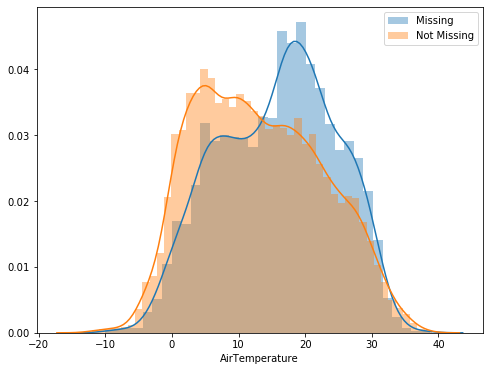

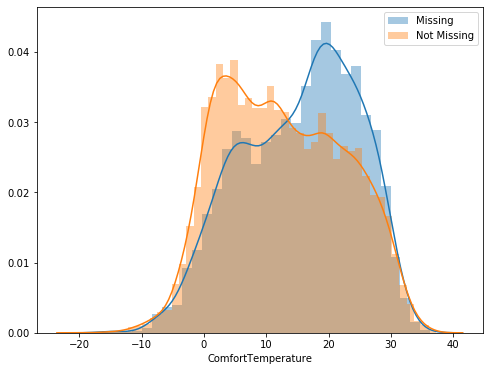

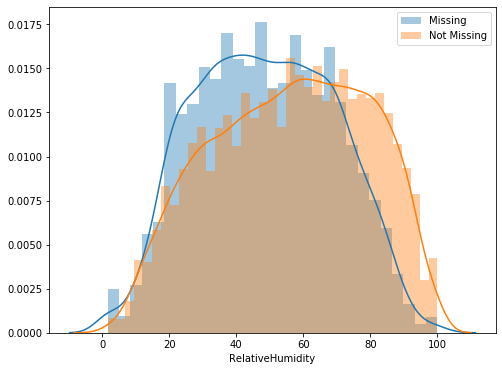

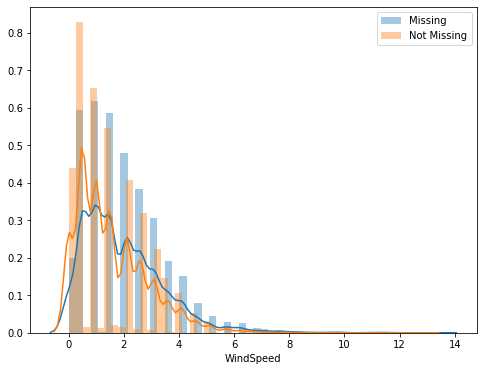

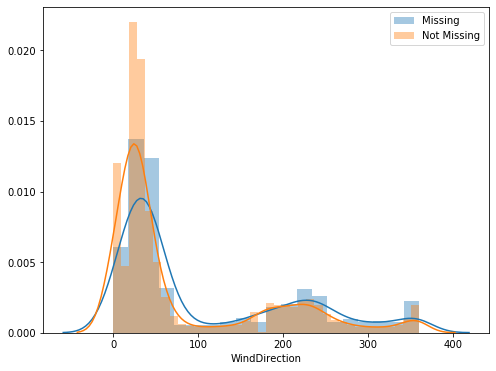

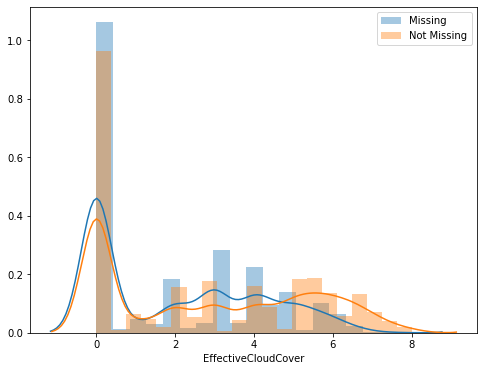

In [13]:
for i in temperature_df.drop(['WWCode', 'isWWMissing'], axis=1).columns:
    plt.figure(figsize=(8,6))
    sns.distplot(temperature_df[temperature_df['isWWMissing']==1][i])
    sns.distplot(temperature_df[temperature_df['isWWMissing']==0][i])  
    plt.legend(["Missing", "Not Missing"])
    plt.show()

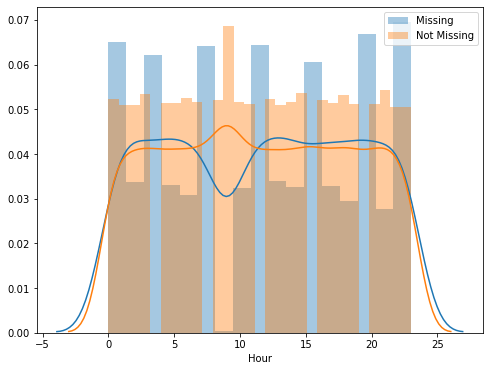

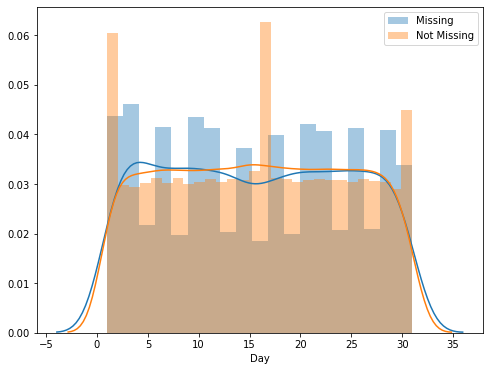

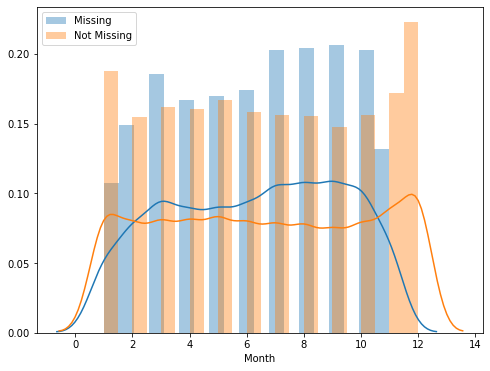

In [20]:
temperature_df["Hour"] = temperature_df.index.hour
temperature_df["Day"] = temperature_df.index.day
temperature_df["Month"] = temperature_df.index.month
temperature_df["Year"] = temperature_df.index.year

for col in ["Hour", "Day", "Month"]:
    plt.figure(figsize=(8,6))
    sns.distplot(temperature_df[temperature_df['isWWMissing']==1][col])
    sns.distplot(temperature_df[temperature_df['isWWMissing']==0][col])  
    plt.legend(["Missing", "Not Missing"])
    plt.show()

In [22]:
temperature_df.groupby("Year")["isWWMissing"].agg(["count",  "sum"])

,count,sum
Year,,
2019,8760,6254
2020,8784,0
2021,8760,0


In [24]:
temperature_df[temperature_df["Year"] == 2019].groupby("Month")["isWWMissing"].agg(["count",  "sum"])

,count,sum
Month,,
1,744,353
2,672,491
3,744,611
4,720,549
5,744,558
6,720,574
7,744,667
8,744,672
9,720,678


In [28]:
pd.merge(generation_df, temperature_df["WWCode"], left_index=True, right_index=True).groupby("WWCode").sum()

,Generation
WWCode,
0.0,589334.334015
1.0,131538.154432
2.0,283909.744253
3.0,194772.683371
4.0,125260.690654
5.0,142200.739787
6.0,43656.016588
7.0,10075.305992
8.0,130.704977


In [39]:
datetime_df = pd.merge(generation_df, temperature_df["WWCode"], left_index=True, right_index=True)
datetime_df["Month"] = datetime_df.index.month
datetime_df["Day"] = datetime_df.index.day
datetime_df["Hour"] = datetime_df.index.hour
print("WWCode - Month")
display(datetime_df.pivot_table(index="WWCode", columns='Month',values='Generation', aggfunc='count').fillna(0))
print("WWCode - Day")
display(datetime_df.pivot_table(index="WWCode", columns='Day',values='Generation', aggfunc='count').fillna(0))
print("WWCode - Hour")
display(datetime_df.pivot_table(index="WWCode", columns='Hour',values='Generation', aggfunc='count').fillna(0))

WWCode - Month


Month,1,2,3,4,5,6,7,8,9,10,11,12
WWCode,,,,,,,,,,,,
0.0,326.0,357.0,422.0,268.0,517.0,347.0,713.0,870.0,737.0,798.0,639.0,201.0
1.0,34.0,42.0,55.0,134.0,129.0,98.0,228.0,287.0,74.0,75.0,25.0,18.0
2.0,109.0,131.0,143.0,208.0,250.0,207.0,308.0,173.0,237.0,175.0,104.0,88.0
3.0,111.0,113.0,122.0,165.0,172.0,172.0,153.0,96.0,142.0,152.0,109.0,77.0
4.0,72.0,99.0,91.0,136.0,111.0,120.0,58.0,51.0,85.0,109.0,91.0,55.0
5.0,183.0,170.0,144.0,121.0,69.0,115.0,20.0,12.0,39.0,64.0,254.0,168.0
6.0,104.0,121.0,102.0,102.0,60.0,51.0,0.0,1.0,10.0,18.0,66.0,87.0
7.0,41.0,35.0,26.0,32.0,19.0,7.0,0.0,0.0,1.0,3.0,9.0,30.0
8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


WWCode - Day


Day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
WWCode,,,,,,,,,,,,,,,,,,,,,
0.0,152.0,188.0,234.0,205.0,204.0,236.0,213.0,190.0,208.0,224.0,...,203.0,199.0,211.0,235.0,253.0,218.0,215.0,177.0,176.0,75.0
1.0,36.0,26.0,35.0,39.0,30.0,36.0,25.0,24.0,28.0,44.0,...,33.0,41.0,39.0,47.0,42.0,38.0,50.0,39.0,40.0,27.0
2.0,66.0,69.0,59.0,53.0,64.0,62.0,75.0,80.0,91.0,72.0,...,53.0,76.0,83.0,61.0,80.0,79.0,67.0,64.0,49.0,38.0
3.0,60.0,56.0,61.0,44.0,70.0,38.0,48.0,53.0,54.0,64.0,...,58.0,57.0,33.0,52.0,41.0,55.0,59.0,57.0,46.0,25.0
4.0,44.0,46.0,41.0,31.0,41.0,45.0,46.0,46.0,48.0,39.0,...,34.0,36.0,16.0,35.0,22.0,40.0,23.0,25.0,33.0,29.0
5.0,42.0,65.0,42.0,56.0,44.0,35.0,28.0,33.0,31.0,31.0,...,60.0,62.0,57.0,50.0,44.0,36.0,50.0,46.0,45.0,22.0
6.0,28.0,38.0,15.0,28.0,37.0,22.0,7.0,21.0,12.0,18.0,...,20.0,10.0,33.0,12.0,12.0,39.0,24.0,22.0,14.0,25.0
7.0,9.0,6.0,6.0,7.0,8.0,9.0,15.0,6.0,1.0,5.0,...,4.0,5.0,6.0,3.0,6.0,10.0,1.0,4.0,11.0,2.0
8.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


WWCode - Hour


Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
WWCode,,,,,,,,,,,,,,,,,,,,,
0.0,337.0,325.0,339.0,326.0,343.0,340.0,308.0,255.0,213.0,707.0,...,145.0,154.0,136.0,145.0,176.0,192.0,231.0,280.0,282.0,300.0
1.0,53.0,41.0,35.0,56.0,27.0,33.0,52.0,57.0,22.0,16.0,...,24.0,71.0,36.0,45.0,94.0,63.0,52.0,111.0,69.0,47.0
2.0,77.0,56.0,39.0,119.0,51.0,47.0,59.0,61.0,99.0,58.0,...,112.0,140.0,100.0,98.0,133.0,92.0,84.0,156.0,64.0,60.0
3.0,52.0,59.0,69.0,44.0,49.0,41.0,49.0,56.0,66.0,14.0,...,88.0,91.0,88.0,88.0,73.0,63.0,74.0,58.0,66.0,72.0
4.0,33.0,34.0,40.0,20.0,45.0,48.0,31.0,34.0,41.0,4.0,...,72.0,57.0,70.0,62.0,55.0,40.0,50.0,30.0,38.0,36.0
5.0,30.0,52.0,48.0,30.0,54.0,47.0,27.0,53.0,61.0,23.0,...,88.0,68.0,90.0,62.0,48.0,51.0,52.0,27.0,48.0,40.0
6.0,39.0,18.0,23.0,34.0,28.0,22.0,37.0,25.0,18.0,4.0,...,29.0,47.0,30.0,28.0,48.0,29.0,22.0,35.0,35.0,34.0
7.0,16.0,3.0,2.0,15.0,4.0,4.0,22.0,5.0,4.0,3.0,...,1.0,25.0,4.0,3.0,29.0,2.0,1.0,13.0,4.0,6.0
8.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Generation (Target) in Time Analysis**

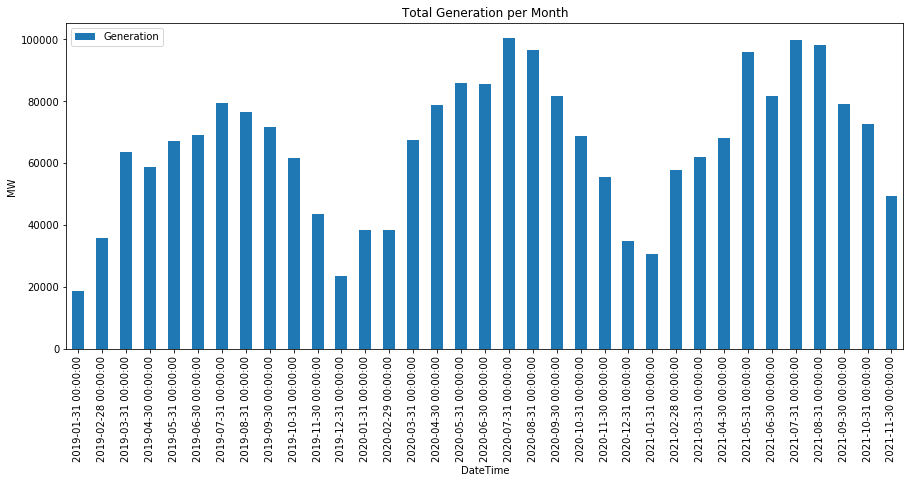

In [103]:
total_generation_per_month = generation_df.resample('M').sum()
total_generation_per_month.plot(kind='bar', figsize=(15,6), title='Total Generation per Month')
plt.ylabel('MW');

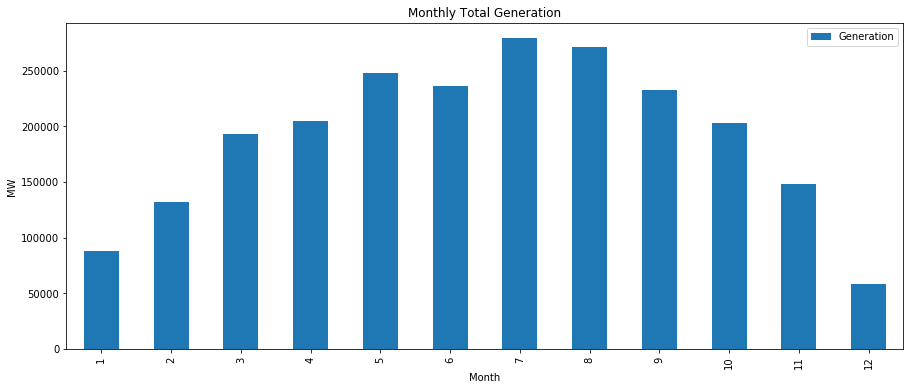

In [104]:
monthly_generation = generation_df.groupby(generation_df.index.month).sum()
monthly_generation.plot(kind='bar', figsize=(15,6), title='Monthly Total Generation')
plt.ylabel('MW')
plt.xlabel('Month');

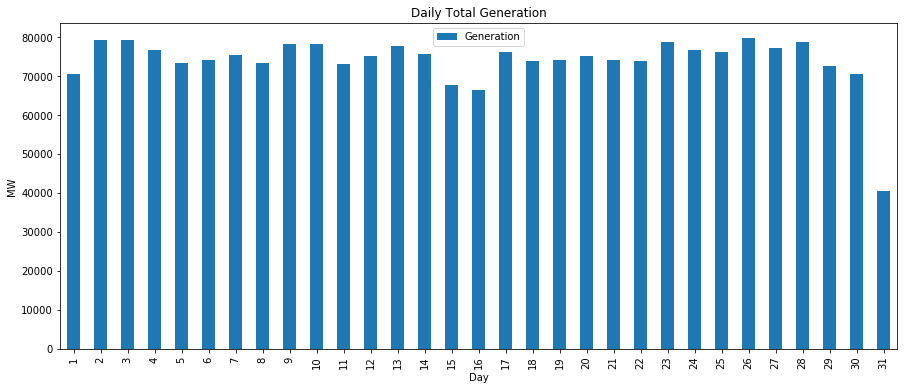

In [105]:
daily_generation = generation_df.groupby(generation_df.index.day).sum()
daily_generation.plot(kind='bar', figsize=(15,6), title='Daily Total Generation')
plt.ylabel('MW')
plt.xlabel('Day');

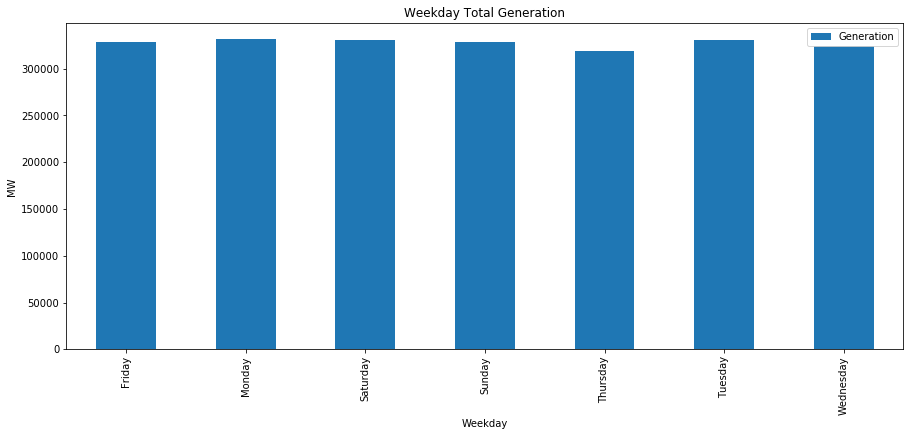

In [106]:
week_day_generation = generation_df.groupby(generation_df.index.day_name()).sum()
week_day_generation.plot(kind='bar', figsize=(15,6), title='Weekday Total Generation')
plt.ylabel('MW')
plt.xlabel('Weekday');

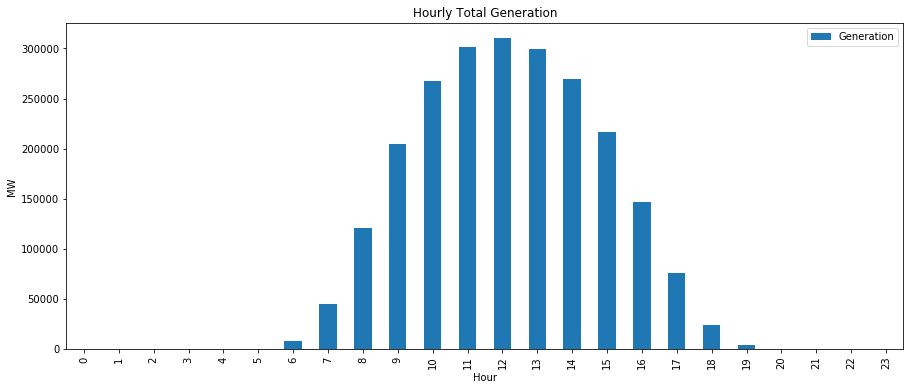

In [107]:
hourly_generation = generation_df.groupby(generation_df.index.hour).sum()
hourly_generation.plot(kind='bar', figsize=(15,6), title='Hourly Total Generation')
plt.ylabel('MW')
plt.xlabel('Hour');

**Distribution of the Data**

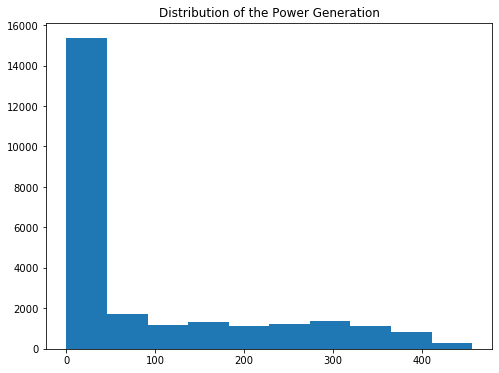

In [108]:
plt.figure(figsize=(8, 6))
plt.hist(generation_df['Generation'])
plt.title("Distribution of the Power Generation");

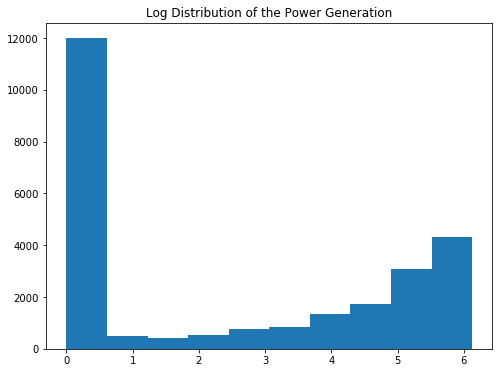

In [109]:
plt.figure(figsize=(8, 6))
plt.hist(np.log1p(generation_df['Generation']))
plt.title("Log Distribution of the Power Generation");

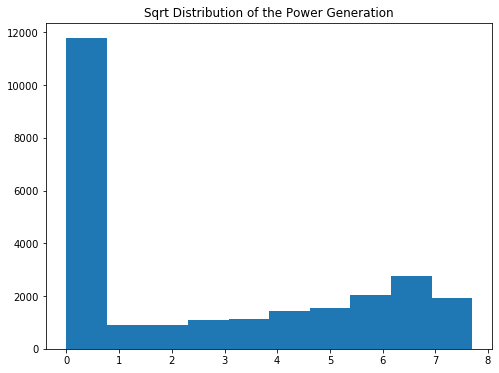

In [110]:
plt.figure(figsize=(8, 6))
plt.hist(np.cbrt(generation_df['Generation']))
plt.title("Sqrt Distribution of the Power Generation");

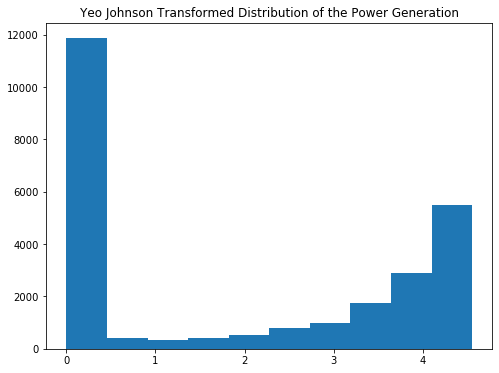

In [111]:
# transform training data & save lambda value
fitted_data, fitted_lambda = stats.yeojohnson(generation_df['Generation'])

plt.figure(figsize=(8, 6))
plt.hist(fitted_data)
plt.title("Yeo Johnson Transformed Distribution of the Power Generation");

In [112]:
capacity_df = {
    'city' : ['Ankara', 'Bartın', 'Karabük', 'Kastamonu', 'Kırıkkale', 'Zonguldak', 'Çankırı'],
    'facility' : [664, 2, 25, 25, 61, 5, 66],
    'capacity(KW)' : [383804.941, 520, 14561.2, 9616.6, 55336.1, 2830, 56336.16],
}

capacity_df = pd.DataFrame(capacity_df)
capacity_df['capacity(MW)'] = capacity_df['capacity(KW)'] * 10e-4
total_capacity_mw = capacity_df['capacity(MW)'].sum()
display(capacity_df)
print("Total Capacity in MW:", total_capacity_mw)

,city,facility,capacity(KW),capacity(MW)
0,Ankara,664,383804.941,383.804941
1,Bartın,2,520.000,0.520000
2,Karabük,25,14561.200,14.561200
3,Kastamonu,25,9616.600,9.616600
4,Kırıkkale,61,55336.100,55.336100
5,Zonguldak,5,2830.000,2.830000
6,Çankırı,66,56336.160,56.336160


Total Capacity in MW: 523.005001


In [113]:
print('Maximum Electric Generated in an hour:', generation_df["Generation"].max(), 'MW')

Maximum Electric Generated in an hour: 456.3193218 MW


In [114]:
#Holidays and Other important dates
turkey_holidays = holidays.TR()

In [115]:
temperature_df['is_holiday'] = [turkey_holidays.get(date) for date in temperature_df.index.date]
temperature_df = temperature_df.merge(pd.get_dummies(temperature_df['is_holiday']), how='inner', left_index=True, right_index=True)
day_of_week_df = pd.get_dummies(pd.DataFrame(temperature_df.index.day_name()).set_index(temperature_df.index).rename(columns = {'DateTime':'Day'}))
temperature_df = temperature_df.merge(day_of_week_df, how='inner', left_index=True, right_index=True)
temperature_df['is_holiday'] = [1 if x is not None else 0 for x in temperature_df['is_holiday']]
temperature_df.head(20)

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,is_holiday,"Commemoration of Ataturk, Youth and Sports Day",Democracy and National Unity Day,...,Sacrifice Feast,Sacrifice Feast Holiday,Victory Day,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-01 05:00:00,-2.1,-6.6,75.2,3.6,60.0,10.0,5.5,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-01 06:00:00,-2.2,-6.2,76.4,3.1,60.0,10.0,6.3,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-01 07:00:00,-2.5,-8.5,79.3,5.7,50.0,10.0,3.5,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-01 08:00:00,-2.5,-8.7,78.1,6.2,50.0,10.0,4.5,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
#K-Means Clustering for the Hours

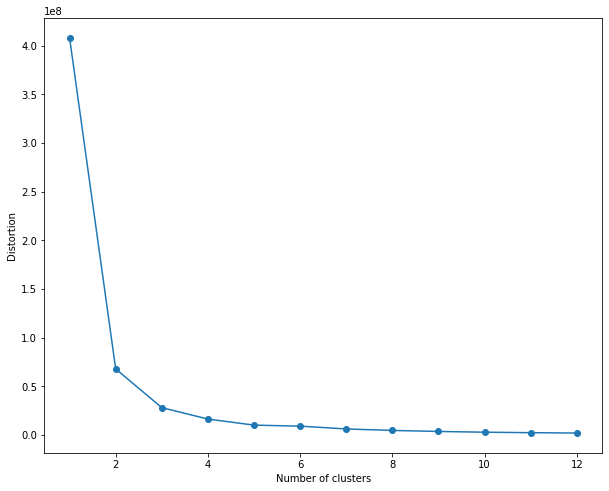

In [117]:
cluster_df = generation_df.copy()
cluster_df["hour"] = cluster_df.index.hour

# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 13):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=421
    )
    km.fit(cluster_df)
    distortions.append(km.inertia_)

# plot
plt.figure(figsize=(10, 8))
plt.plot(range(1, 13), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [118]:
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=421
)
y_km = km.fit_predict(cluster_df)

cluster_df["hour_cluster"] = y_km

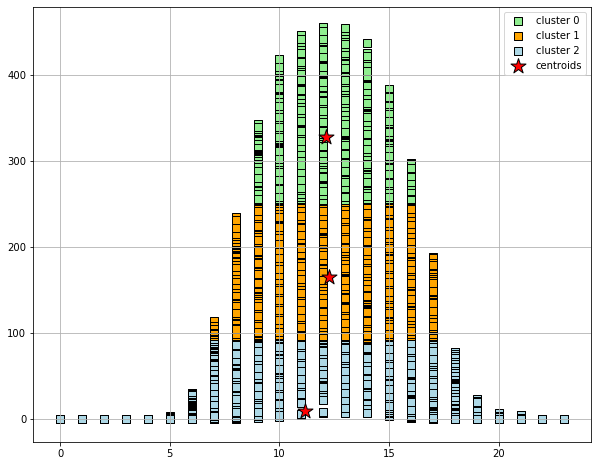

In [119]:
# plot the 3 clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    cluster_df[cluster_df["hour_cluster"] == 0]["hour"], cluster_df[cluster_df["hour_cluster"] == 0]["Generation"],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 0'
)

plt.scatter(
    cluster_df[cluster_df["hour_cluster"] == 1]["hour"], cluster_df[cluster_df["hour_cluster"] == 1]["Generation"],
    s=50, c='orange',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    cluster_df[cluster_df["hour_cluster"] == 2]["hour"], cluster_df[cluster_df["hour_cluster"] == 2]["Generation"],
    s=50, c='lightblue',
    marker='s', edgecolor='black',
    label='cluster 2'
)


# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 1], km.cluster_centers_[:, 0],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [22]:
#Agglomerative Clustering for Hours

In [120]:
cluster_df = cluster_df.drop("hour_cluster", axis=1)

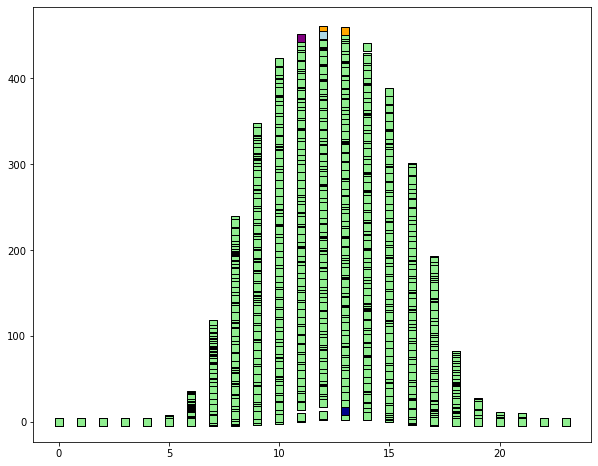

In [121]:
#Agglomerative Clustering

agglo_cl = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='single')
agglo_cl.fit(cluster_df)
labels = agglo_cl.labels_
cluster_df["agglo_cluster"] = labels 

# plot the 3 clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    cluster_df[cluster_df["agglo_cluster"] == 0]["hour"], cluster_df[cluster_df["agglo_cluster"] == 0]["Generation"],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 0'
)

plt.scatter(
    cluster_df[cluster_df["agglo_cluster"] == 1]["hour"], cluster_df[cluster_df["agglo_cluster"] == 1]["Generation"],
    s=50, c='orange',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    cluster_df[cluster_df["agglo_cluster"] == 2]["hour"], cluster_df[cluster_df["agglo_cluster"] == 2]["Generation"],
    s=50, c='lightblue',
    marker='s', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    cluster_df[cluster_df["agglo_cluster"] == 3]["hour"], cluster_df[cluster_df["agglo_cluster"] == 3]["Generation"],
    s=50, c='purple',
    marker='s', edgecolor='black',
    label='cluster 3'
)


plt.scatter(
    cluster_df[cluster_df["agglo_cluster"] == 4]["hour"], cluster_df[cluster_df["agglo_cluster"] == 4]["Generation"],
    s=50, c='darkblue',
    marker='s', edgecolor='black',
    label='cluster 4'
)


In [122]:
hourly_generation

,Generation
DateTime,
0,0.735458
1,0.544739
2,1.003148
3,0.535501
4,4.502115
5,289.756533
6,7676.716704
7,44988.103805
8,121269.468751


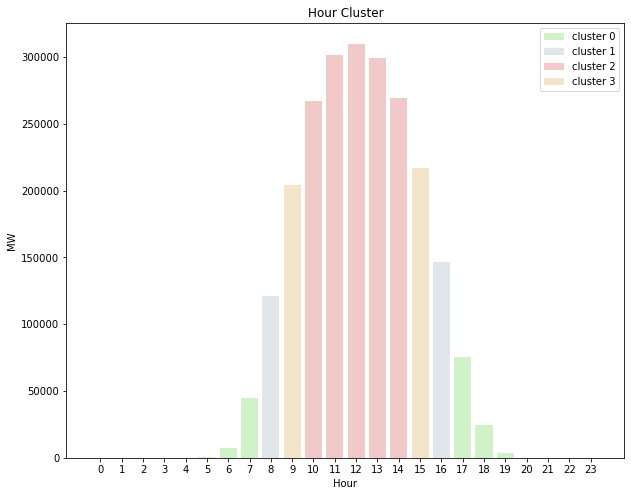

In [123]:
import scipy.cluster.hierarchy as sch

agglo_cl = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
agglo_cl.fit(hourly_generation)
labels = agglo_cl.labels_
hourly_generation["agglo_cluster"] = labels 
hourly_generation_2 = hourly_generation.reset_index()
hourly_generation_2.rename(columns={"DateTime": 'Hour'}, inplace=True) 
# plot the 3 clusters
plt.figure(figsize=(10, 8))
plt.bar(
    hourly_generation_2[hourly_generation_2["agglo_cluster"] == 0]["Hour"], hourly_generation_2[hourly_generation_2["agglo_cluster"] == 0]["Generation"],
    #s=50, 
    color='#d1f2c9',
    #marker='s', edgecolor='black',
    label='cluster 0'
)

plt.bar(
    hourly_generation_2[hourly_generation_2["agglo_cluster"] == 1]["Hour"], hourly_generation_2[hourly_generation_2["agglo_cluster"] == 1]["Generation"],
    #s=50, 
    color='#e1e6eb',
    #marker='s', edgecolor='black',
    label='cluster 1'
)

plt.bar(
    hourly_generation_2[hourly_generation_2["agglo_cluster"] == 2]["Hour"], hourly_generation_2[hourly_generation_2["agglo_cluster"] == 2]["Generation"],
    #s=50, 
    color='#f2c9c9',
    #marker='s', edgecolor='black',
    label='cluster 2'
)

plt.bar(
    hourly_generation_2[hourly_generation_2["agglo_cluster"] == 3]["Hour"], hourly_generation_2[hourly_generation_2["agglo_cluster"] == 3]["Generation"],
    #s=50, 
    color='#f2e5c9',
    #marker='s', edgecolor='black',
    label='cluster 3'
)
plt.title("Hour Cluster")
plt.xlabel("Hour")
plt.ylabel("MW")
plt.xticks(hourly_generation_2["Hour"])
plt.legend();

In [124]:
hourly_generation_2

,Hour,Generation,agglo_cluster
0,0,0.735458,0
1,1,0.544739,0
2,2,1.003148,0
3,3,0.535501,0
4,4,4.502115,0
5,5,289.756533,0
6,6,7676.716704,0
7,7,44988.103805,0
8,8,121269.468751,1
9,9,204467.387191,3


In [125]:
temperature_df["Hour"] = temperature_df.index.hour
temperature_df["DayGroup"] = temperature_df["Hour"].map(hourly_generation_2["agglo_cluster"].to_dict())
temperature_df[["Hour", "DayGroup"]].drop_duplicates()

,Hour,DayGroup
DateTime,,
2019-01-01 00:00:00,0,0
2019-01-01 01:00:00,1,0
2019-01-01 02:00:00,2,0
2019-01-01 03:00:00,3,0
2019-01-01 04:00:00,4,0
2019-01-01 05:00:00,5,0
2019-01-01 06:00:00,6,0
2019-01-01 07:00:00,7,0
2019-01-01 08:00:00,8,1


**Correlation Analysis**

In [40]:
merged_df = pd.merge(generation_df, temperature_df,left_index=True, right_index=True)
merged_df.head()

,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,isWWMissing,Hour,Day,Month,Year
DateTime,,,,,,,,,,,,,
2019-01-01 00:00:00,0.000000,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,0,0,1,1,2019
2019-01-01 01:00:00,0.000000,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,0,1,1,1,2019
2019-01-01 02:00:00,0.000008,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5,0,2,1,1,2019
2019-01-01 03:00:00,0.000000,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6,0,3,1,1,2019
2019-01-01 04:00:00,0.000008,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5,0,4,1,1,2019


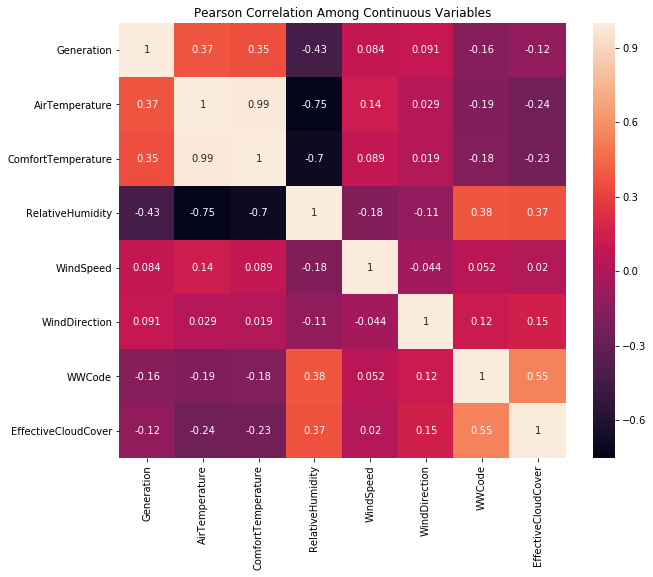

In [42]:
contiuous = ['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed', 
        'WindDirection', 'WWCode', 'EffectiveCloudCover']

binary = ['is_holiday',
       'Commemoration of Ataturk, Youth and Sports Day',
       'Democracy and National Unity Day', 'Labour Day',
       "National Sovereignty and Children's Day", "New Year's Day",
       'Ramadan Feast', 'Ramadan Feast Holiday', 'Republic Day',
       'Sacrifice Feast', 'Sacrifice Feast Holiday', 'Victory Day',
       'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']

multicat = ['DayGroup']
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df[['Generation']+contiuous].corr('pearson'), annot=True)
plt.title("Pearson Correlation Among Continuous Variables")
plt.show();

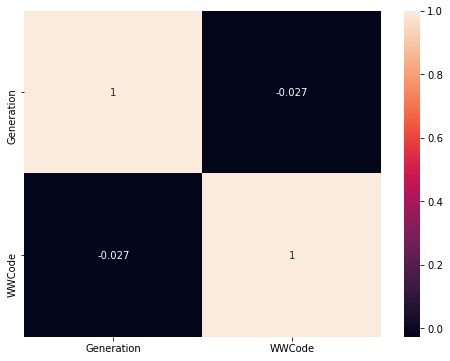

In [43]:
plt.figure(figsize=(8,6))
sns.heatmap(merged_df[['Generation']+['WWCode']].corr('spearman'), annot=True);

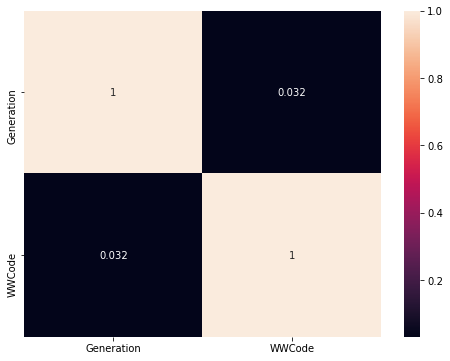

In [64]:
plt.figure(figsize=(8,6))
sns.heatmap(merged_df[merged_df.index.year.isin(['2020', '2021'])][['Generation']+['WWCode']].corr('spearman'), annot=True);

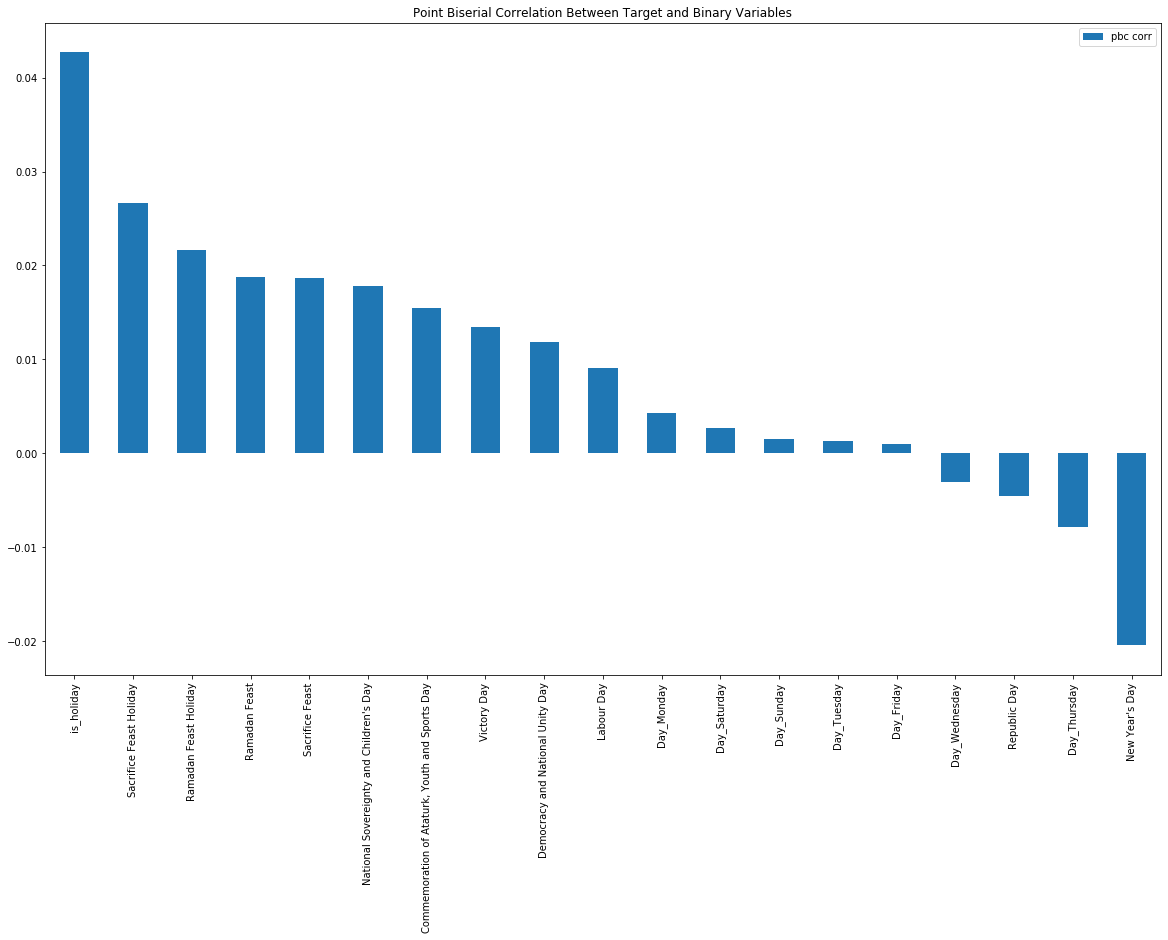

In [130]:
pbc_dict = {}

for col in binary:
    pbc, p_val = pointbiserialr(merged_df['Generation'], merged_df[col])
    pbc_dict[col] = [pbc, p_val]
pbc = pd.DataFrame(pbc_dict, index=["pbc corr", 'p_value']).T
pbc[['pbc corr']].sort_values('pbc corr', ascending=False).plot(kind='bar')
plt.title("Point Biserial Correlation Between Target and Binary Variables");

In [208]:
mod = ols('Generation ~ DayGroup', data=merged_df[["Generation", "DayGroup"]]).fit()

aov_t = sm.stats.anova_lm(mod, typ=2)
print(aov_t)
print("Effect Size for Multicategorical DayGroup and Target")
print("eta-square:", aov_t['sum_sq'][0]/(aov_t['sum_sq'][0]+aov_t['sum_sq'][1]))

                sum_sq       df             F  PR(>F)
DayGroup  2.595588e+08      1.0  45012.517483     0.0
Residual  1.473769e+08  25558.0           NaN     NaN
Effect Size for Multicategorical DayGroup and Target
eta-square: 0.637837429685757


In [209]:
mod = ols('Generation ~ WWCode', data=merged_df[["Generation", "WWCode"]]).fit()

aov_t = sm.stats.anova_lm(mod, typ=2)
print(aov_t)
print("Effect Size for Multicategorical WWCode and Target")
print("eta-square:", aov_t['sum_sq'][0]/(aov_t['sum_sq'][0]+aov_t['sum_sq'][1]))

                sum_sq       df           F         PR(>F)
WWCode    8.302552e+06      1.0  511.068423  1.044831e-111
Residual  3.136028e+08  19304.0         NaN            NaN
Effect Size for Multicategorical WWCode and Target
eta-square: 0.02579190807791746


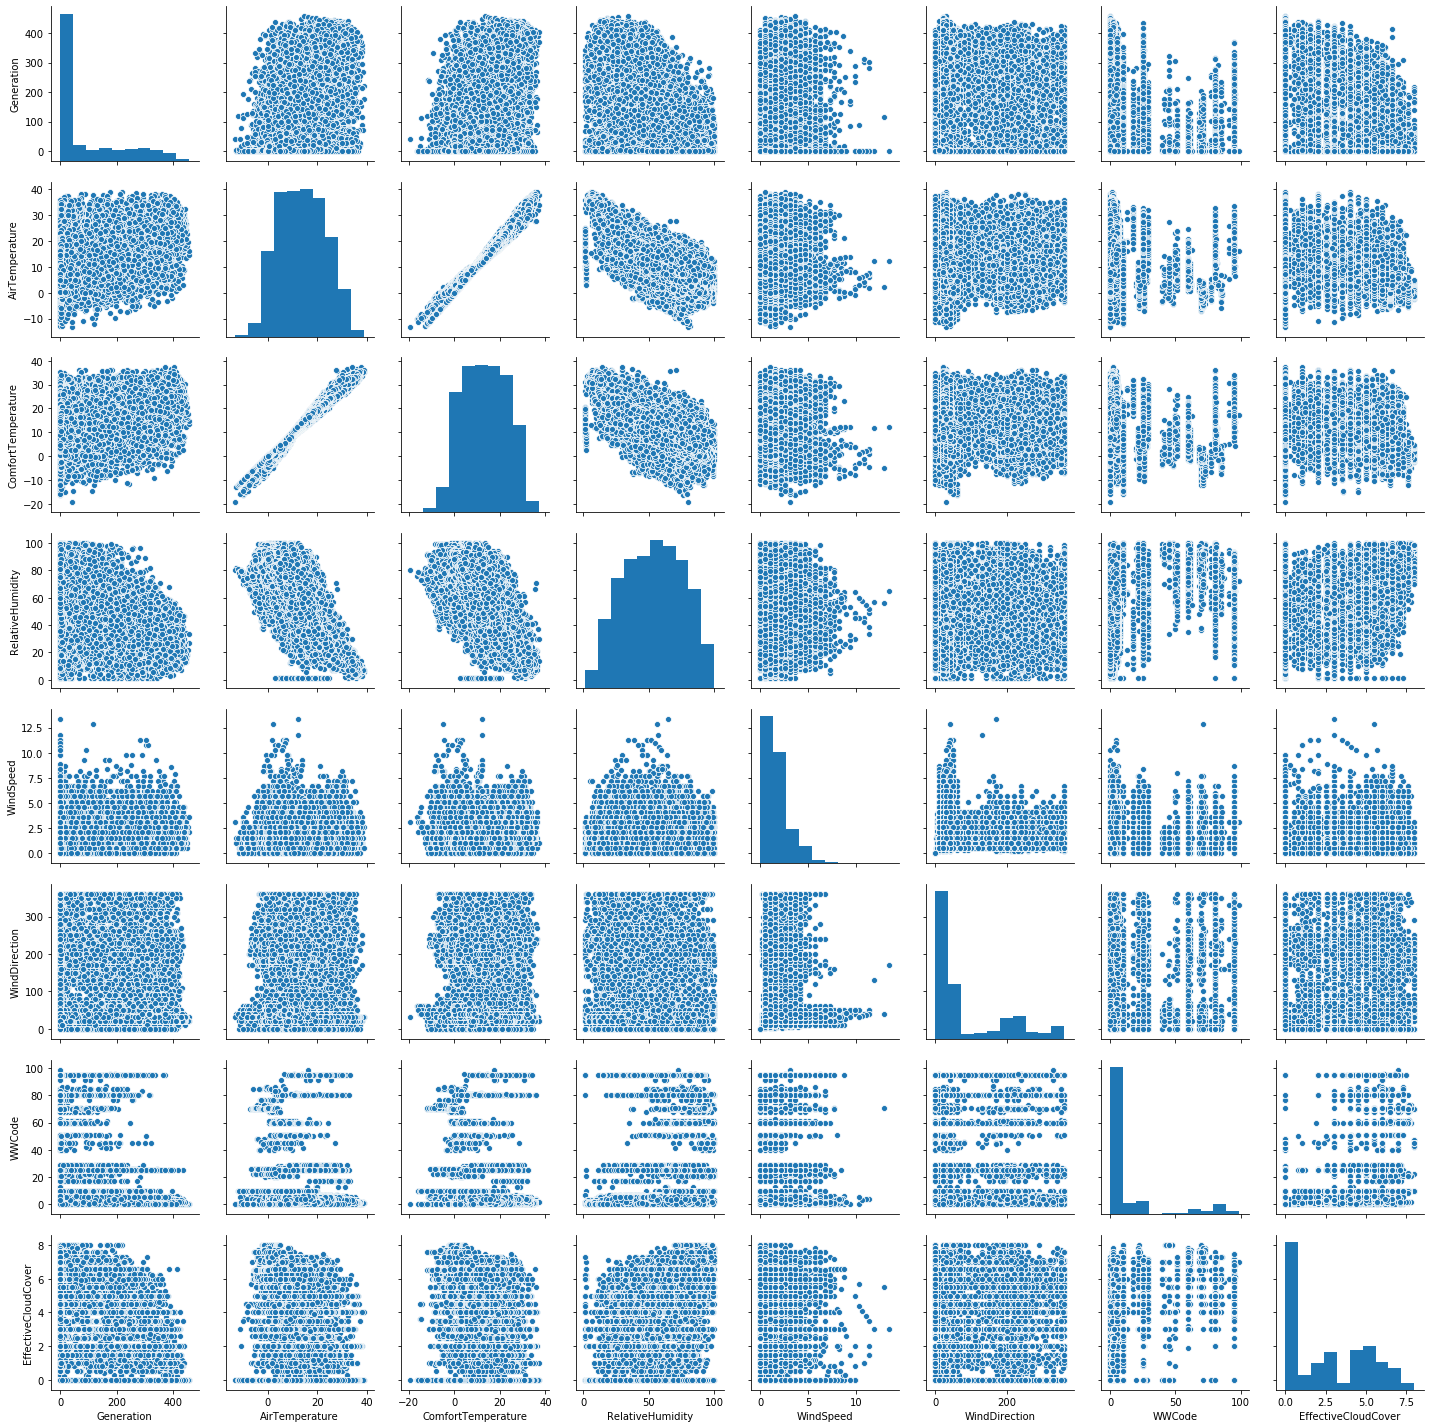

In [133]:
sns.pairplot(merged_df[["Generation"]+contiuous]);

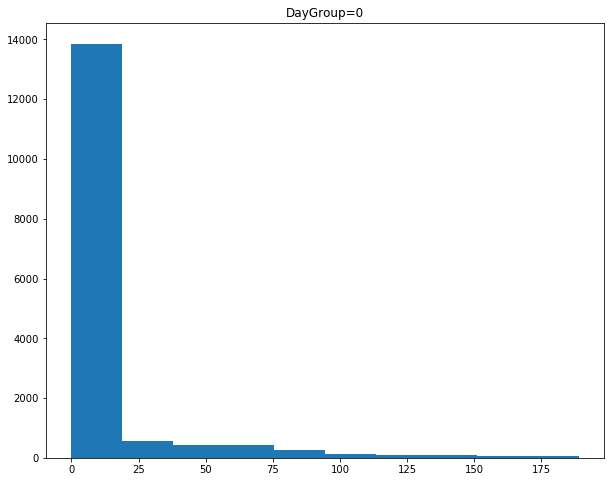

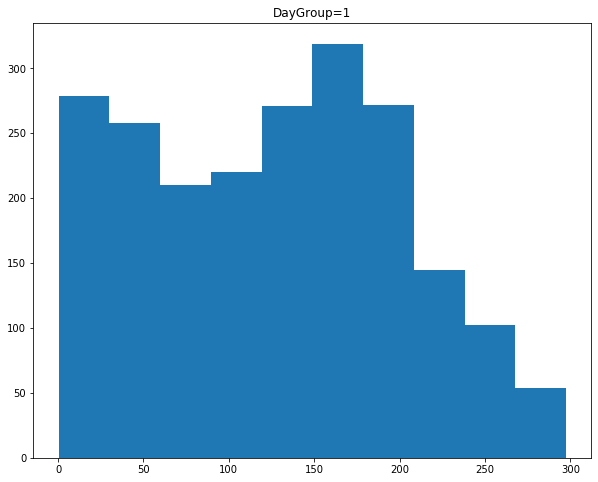

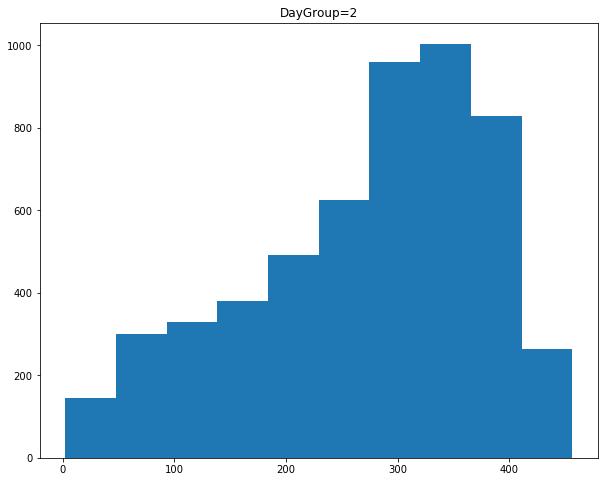

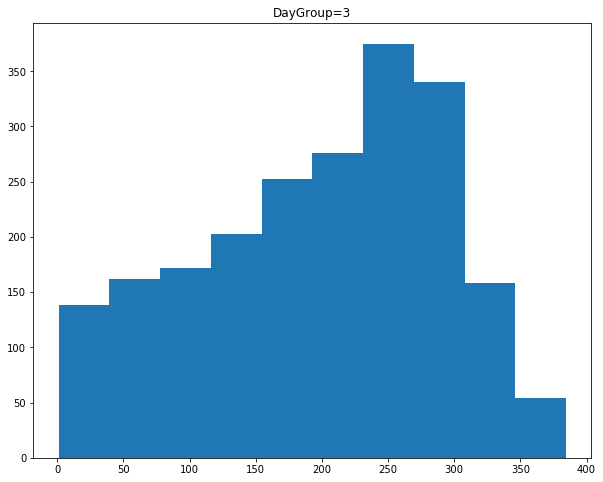

In [134]:
for i in sorted(merged_df["DayGroup"].unique()):
    plt.figure(figsize=(10,8))
    plt.hist(merged_df[merged_df['DayGroup']==i]['Generation'])
    plt.title("DayGroup={}".format(i))
    plt.show()

**Time Series Analysis**

In [38]:
#Stationarity Check

In [135]:
#Apply KPSS test 

def run_kpss(series):
    verdict = 'KPSS: Series is NON-STATIONARY with a p-value ='
    result = kpss(series)
    if result[1] > 0.05: verdict='KPSS: Series is STATIONARY with a p-value ='
    print(verdict, result[1])
    
# Apply to the data
run_kpss(generation_df["Generation"])

KPSS: Series is NON-STATIONARY with a p-value = 0.01


c:\python37\lib\site-packages\statsmodels\tsa\stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [136]:
#Since KPSS test is non stationary, we apply ADF test 

def run_adf(series):
    verdict = 'ADF: Series is NON-STATIONARY with a p-value ='
    result = adfuller(series)
    if result[1] <= 0.05: verdict='ADF: Series is STATIONARY with a p-value ='
    print(verdict, result[1])
    
# Apply to the data
run_adf(generation_df["Generation"])    

ADF: Series is STATIONARY with a p-value = 1.3356413374560469e-17


In [137]:
print("Numeber of Observations in 2019:",generation_df['2019'].count().values[0])
print("Numeber of Observations in 2020:",generation_df['2020'].count().values[0])
print("Numeber of Observations in 2021:",generation_df['2021'].count().values[0])

Numeber of Observations in 2019: 8760
Numeber of Observations in 2020: 8784
Numeber of Observations in 2021: 8016


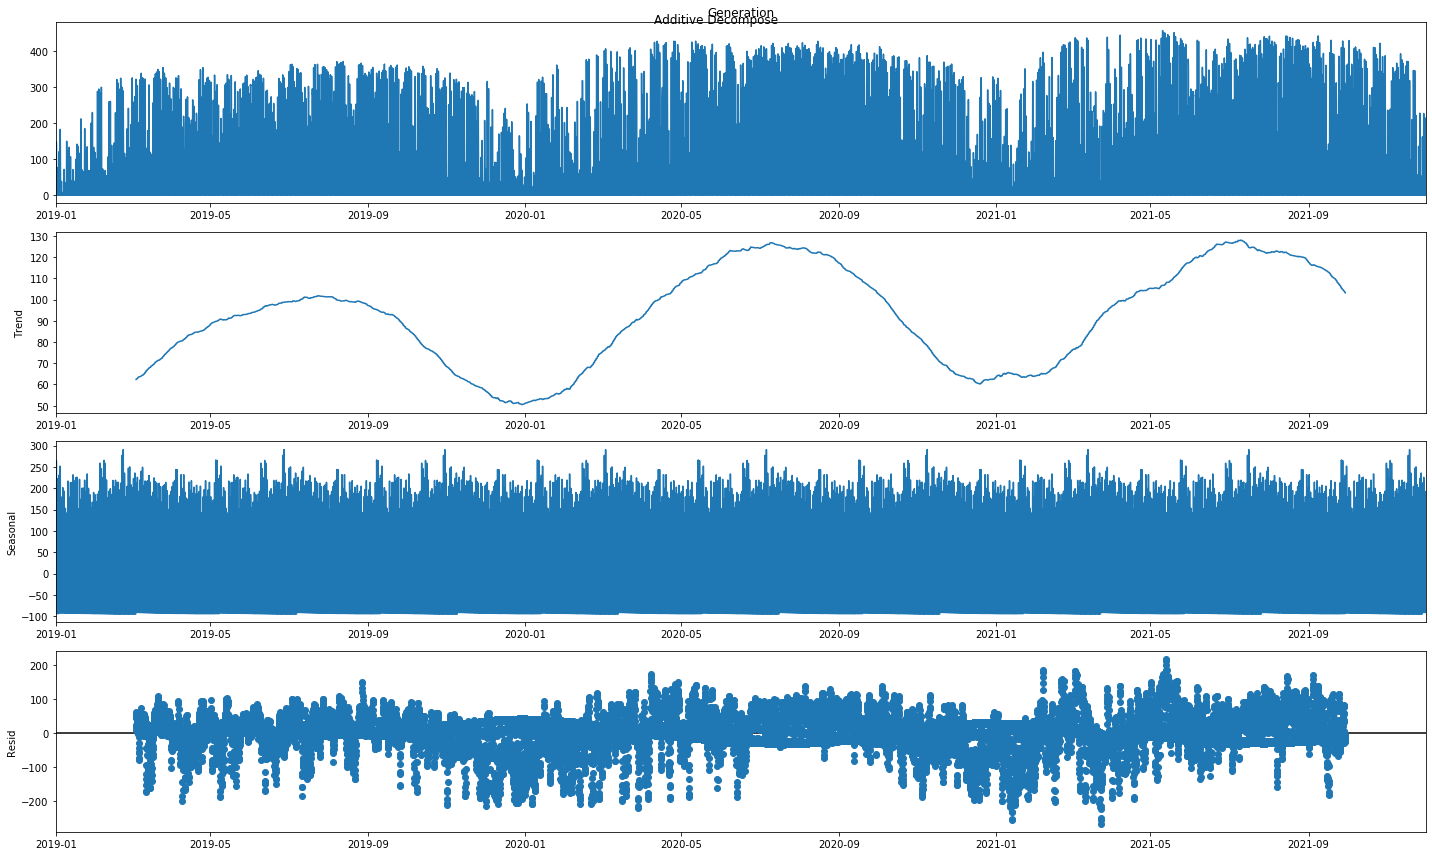

In [138]:
# Additive Decomposition
result = seasonal_decompose(generation_df["Generation"], model='additive',period=3000)

plt.rcParams.update({'figure.figsize': (20,12)})
result.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

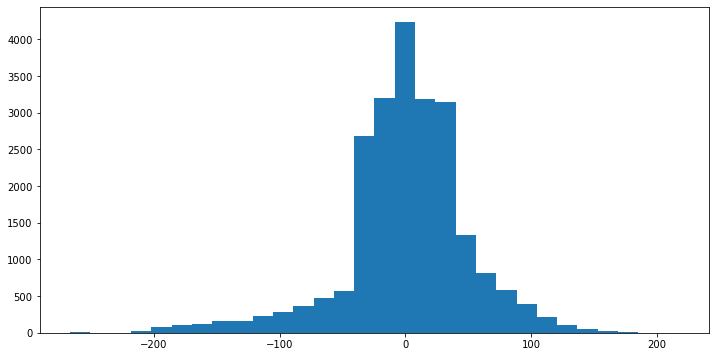

In [43]:
plt.figure(figsize=(12, 6))
plt.hist(result.resid, bins=30);

In [44]:
run_kpss(result.resid.dropna())
run_adf(result.resid.dropna())
# Decomposition leaves NaN values in the series, hence dropna()

c:\python37\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


KPSS: Series is STATIONARY with a p-value = 0.1
ADF: Series is STATIONARY with a p-value = 4.730792160659822e-27


In [45]:
#Autocorrelation Analysis

In [46]:
def plot_corr(series, lags):
    plt.figure(figsize=(16, 4))
    
    plt.subplot(121)
    lag_acf = acf(series, nlags=lags)
    plt.stem(lag_acf)
    plt.axhline(y=0,linestyle='-',color='black')
    plt.axhline(y=-1.96/np.sqrt(len(series)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(series)),linestyle='--',color='gray')
    plt.xlabel('Lag') ; plt.ylabel('ACF')
    
    plt.subplot(122)
    lag_pacf = pacf(series, nlags=lags)
    plt.stem(lag_pacf)
    plt.axhline(y=0,linestyle='-',color='black')
    plt.axhline(y=-1.96/np.sqrt(len(series)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(series)),linestyle='--',color='gray')
    plt.xlabel('Lag') ; plt.ylabel('PACF')
    plt.show()

c:\python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
c:\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


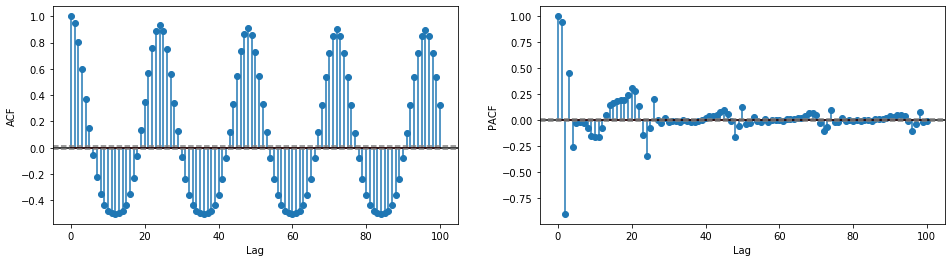

In [47]:
plot_corr(generation_df["Generation"], 100)

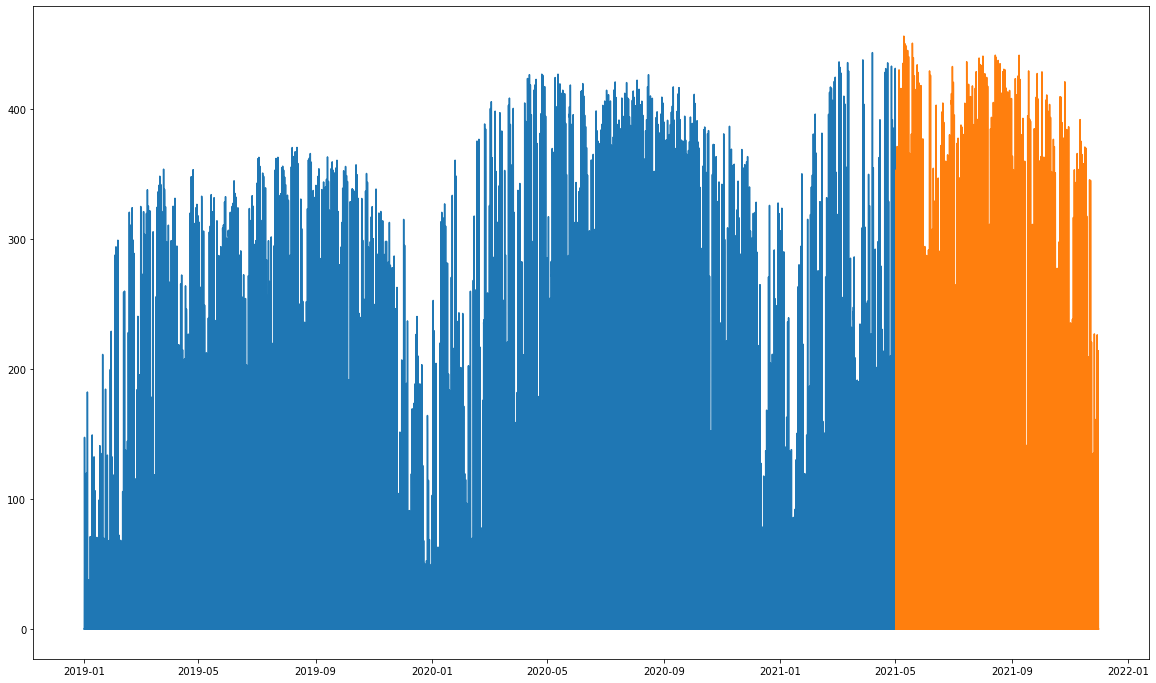

In [49]:
#Split data to train and test split
train = generation_df[:int(len(generation_df)*0.8)]
test = generation_df[int(len(generation_df)*0.8):] 

plt.plot(train)
plt.plot(test);

In [63]:
#Build an Auto ARIMA Model

In [51]:
arima_model = auto_arima(
    train,
    start_p=0,
    d=0,
    start_q=0,
    max_p=2,
    max_d=2,
    max_q=2,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=2,
    max_D=0,
    max_Q=2,
    #max_order=5,
    m=24,
    seasonal=True,
    stationary=False,
    information_criterion='aic',
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',
    stepwise=True,
    n_jobs=1,
    start_params=None,
    trend=None,
    method='lbfgs',
    maxiter=20,
    offset_test_args=None,
    seasonal_test_args=None,
    suppress_warnings=True,
    error_action='trace',
    trace=False,
    random=False,
    random_state=421,
    n_fits=10,
    return_valid_fits=False,
    out_of_sample_size=0,
    scoring='mse',
    scoring_args=None,
    with_intercept='auto',
    sarimax_kwargs=None)

KeyboardInterrupt: 

In [84]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                20448
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -83946.666
Date:                Sat, 19 Feb 2022   AIC                         167905.333
Time:                        22:01:10   BIC                         167952.887
Sample:                             0   HQIC                        167920.874
                              - 20448                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.4070      0.359     26.185      0.000       8.703      10.111
ar.L1          1.6655      0.005    364.976      0.000       1.657       1.674
ar.L2         -0.7773      0.005   -167.442      0.000      -0.786      -0.768
ma.L1          0.6614      0.007     95.874      0.000       0.648       0.675
ma.L2          0.1926      0.007     27.004      0.000       0.179       0.207
sigma2       215.4138      1.709    126.031      0.000     212.064     218.764
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):              9816.09
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
arima_pred_df = pd.DataFrame(arima_model.predict(len(test)), index=test.index[:])
arima_pred_df.columns = ['arima_preds']
arima_pred_df.head(10)

,arima_preds
DateTime,
2021-05-02 00:00:00,5.244806
2021-05-02 01:00:00,16.978837
2021-05-02 02:00:00,33.608733
2021-05-02 03:00:00,52.185277
2021-05-02 04:00:00,70.198468
2021-05-02 05:00:00,85.760270
2021-05-02 06:00:00,97.677140
2021-05-02 07:00:00,105.428775
2021-05-02 08:00:00,109.076330


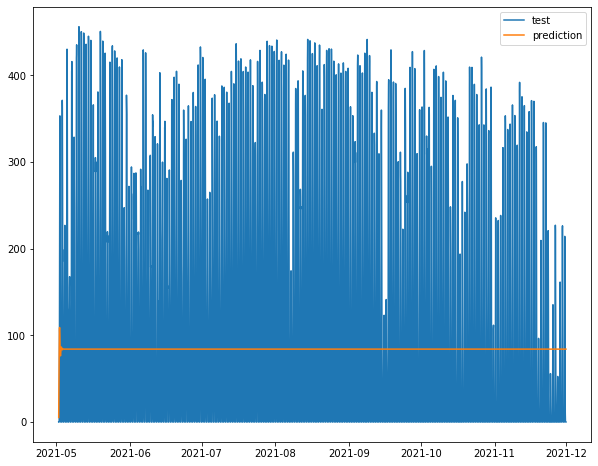

In [89]:
plt.figure(figsize=(10, 8))
#plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(arima_pred_df,label='prediction')
plt.legend()
plt.show()

In [ ]:
#Prepare data for models

In [139]:
generation_df.to_csv('generation_data.csv')
temperature_df.to_csv('features_data.csv')